# Data Science Test - Ming Li

## Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np

In [2]:
import json

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [171]:
import pyro
import torch

from torch import nn
from torch.nn import BCELoss

from pyro.optim import Adam, SGD
from pyro.infer import Trace_ELBO, SVI, TracePredictive, EmpiricalMarginal
from pyro.infer.mcmc import NUTS
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc.util import diagnostics, initialize_model, summary

from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.distributions import Normal, Uniform, Bernoulli, Delta

In [6]:
plt.style.use("ggplot")
plt.rcParams["figure.dpi"] = 100

In [7]:
df_raw_cust = pd.read_csv("./customer-data.csv")

In [8]:
df_raw_cust.info(null_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
id                     10000 non-null int64
age                    10000 non-null object
gender                 10000 non-null object
race                   10000 non-null object
driving_experience     10000 non-null object
education              10000 non-null object
income                 10000 non-null object
credit_score           9018 non-null float64
vehicle_ownership      10000 non-null bool
vehicle_year           10000 non-null object
married                10000 non-null bool
children               10000 non-null bool
postal_code            10000 non-null int64
annual_mileage         9043 non-null float64
vehicle_type           10000 non-null object
speeding_violations    10000 non-null int64
DUIs                   10000 non-null int64
past_accidents         10000 non-null int64
outcome                10000 non-null bool
dtypes: bool(4), float64(2), int64(5), object(8)
m

In [9]:
df_raw_cust.head().transpose()

,0,1,2,3,4
id,569520,750365,199901,478866,731664
age,65+,16-25,16-25,16-25,26-39
gender,female,male,female,male,male
race,majority,majority,majority,majority,majority
driving_experience,0-9y,0-9y,0-9y,0-9y,10-19y
education,high school,none,high school,university,none
income,upper class,poverty,working class,working class,working class
credit_score,0.629027,0.357757,0.493146,0.206013,0.388366
vehicle_ownership,True,False,True,True,True
vehicle_year,after 2015,before 2015,before 2015,before 2015,before 2015


In [10]:
df_raw_cust.loc[:, "outcome"].value_counts()

False    6867
True     3133
Name: outcome, dtype: int64

### Q1. what proportion of customers with credit_score under .2 made a claim?

In [11]:
df_score_claim = df_raw_cust.loc[:, ["credit_score", "outcome"]].copy()

In [12]:
# p(claim | c < .2) = p(claim, c < .2) / p(c < .2)
joint = df_score_claim.loc[(df_score_claim["outcome"]) & (df_score_claim["credit_score"] < .2)]
z = df_score_claim.loc[df_score_claim["credit_score"] < .2]

In [13]:
# conditional
joint.shape[0] / z.shape[0]

0.6020408163265306

### Q2. average number of speeding violations 20 - 29 years of driving? what if sport cars only in this group?

In [14]:
df_speeding_20_29 = df_raw_cust.loc[df_raw_cust["driving_experience"] == "20-29y", ["speeding_violations", "vehicle_type"]]

In [15]:
df_speeding_20_29["speeding_violations"].mean()

2.734308636149127

In [16]:
df_speeding_20_29.loc[df_speeding_20_29["vehicle_type"] == "sports car", "speeding_violations"].mean()

2.7777777777777777

### Q3. what's the annual mileage standard deviation?

In [17]:
df_raw_cust["annual_mileage"].std()

2818.434528301786

## Inference using Logistic Regression

In [18]:
df_cust = df_raw_cust.drop("id", axis=1).dropna()

In [19]:
transformation_dict = {}
# turn categorical features into numerical values
multinominal = []
for col in df_cust.select_dtypes(include=["object"]):
    df_cust.loc[:, col] = df_cust.loc[:, col].astype("category")
    if len(df_cust.loc[:, col].cat.categories) > 2:
        multinominal.append(col)

    transformation_dict.update(
        {col: {k: v for (v, k) in enumerate(df_cust.loc[:, col].cat.categories)}})

for col in df_cust.select_dtypes(include=["bool"]):
    df_cust.loc[:, col] = df_cust.loc[:, col].astype(int)

transformation_dict.update(
    {"education": {"none": 0, "high school": 1, "university": 2},
     "income": {'middle class': 2, "poverty": 0, "upper class": 3, "working class": 1}})

In [20]:
print(json.dumps(transformation_dict, indent=4))

{
    "age": {
        "16-25": 0,
        "26-39": 1,
        "40-64": 2,
        "65+": 3
    },
    "gender": {
        "female": 0,
        "male": 1
    },
    "race": {
        "majority": 0,
        "minority": 1
    },
    "driving_experience": {
        "0-9y": 0,
        "10-19y": 1,
        "20-29y": 2,
        "30y+": 3
    },
    "education": {
        "none": 0,
        "high school": 1,
        "university": 2
    },
    "income": {
        "middle class": 2,
        "poverty": 0,
        "upper class": 3,
        "working class": 1
    },
    "vehicle_year": {
        "after 2015": 0,
        "before 2015": 1
    },
    "vehicle_type": {
        "sedan": 0,
        "sports car": 1
    }
}


In [21]:
df_cust = df_cust.replace(transformation_dict)

In [23]:
rf = RandomForestClassifier(n_estimators=100)

In [56]:
rf.fit(df_cust.loc[:, df_cust.columns.difference(["outcome"])], df_cust["outcome"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [62]:
# feature importance per decision tree estimator
feats_imporances = np.array([rf.estimators_[i].feature_importances_ for i in range(rf.n_estimators)])
assert np.allclose(feats_imporances.mean(0), rf.feature_importances_)
feats_df = pd.DataFrame(feats_imporances, columns=df_cust.loc[:, df_cust.columns.difference(["outcome"])].columns)

Text(0.5, 1.0, 'feature importance (95% CI, n=100) using Decision Tree')

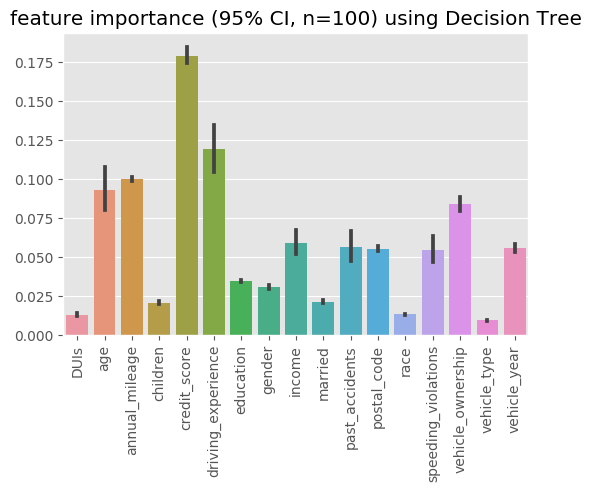

In [63]:
sns.barplot(data=feats_df, ci=95)
plt.xticks(rotation=90)
plt.title("feature importance (95% CI, n=100) using Decision Tree")

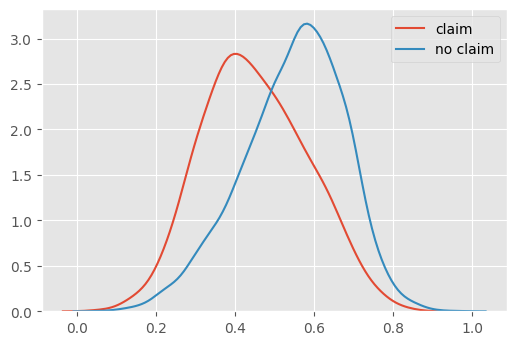

In [64]:
sns.kdeplot(df_cust["credit_score"][df_cust["outcome"] == 1], label="claim")
sns.kdeplot(df_cust["credit_score"][df_cust["outcome"] == 0], label="no claim")

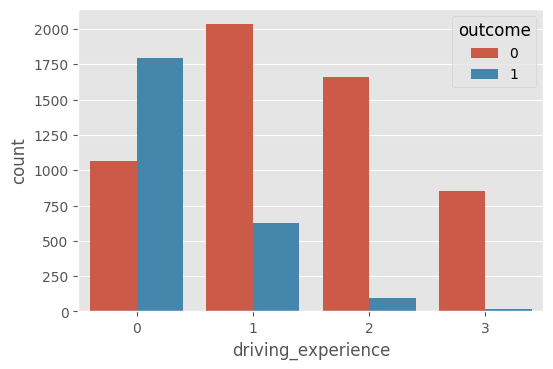

In [65]:
sns.countplot(x="driving_experience", hue="outcome", data=df_cust)

In [100]:
# toy hypothesis, do men and women have same likelihood to make a claim?

In [101]:
from statsmodels.stats.proportion import proportions_ztest

In [102]:
z, p = proportions_ztest(df_cust.loc[:, ["gender", "outcome"]].groupby("gender").sum()["outcome"],
                         df_cust["gender"].value_counts(),
                         value=0)
print(f"reject null hypothesis of no difference: {p < .01}")

reject null hypothesis of no difference: True


In [103]:
# TODO more robust perhaps
top_k_feats = feats_imporances.mean(axis=0).argsort()[-3:]

In [135]:
df_cust_subset = \
    df_cust.loc[:, df_cust.loc[:, df_cust.columns.difference(["outcome"])].columns[top_k_feats].tolist() + ["gender", "outcome"]].copy()

In [197]:
df_cust_subset = df_cust.loc[:, ["income", "outcome"]].copy()

/root/.virtualenvs/faculty/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/root/.virtualenvs/faculty/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


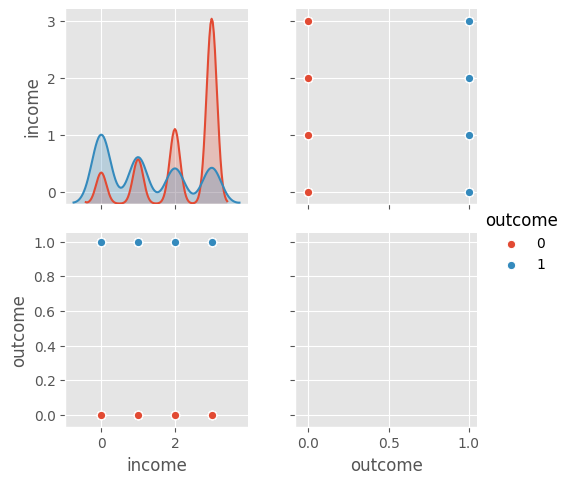

In [198]:
sns.pairplot(df_cust_subset, hue="outcome")

In [199]:
class TorchLogisticRegression(nn.Module):
    def __init__(self, p):
        super(TorchLogisticRegression, self).__init__()
        # nn.Linear includes p weights and 1 bias.
        self.linear = nn.Linear(p, 1)
        self.nonlinearity = nn.Sigmoid()

    def logit(self, x):
        return self.linear(x)

    def forward(self, z):
        return self.nonlinearity(self.logit(z))

In [200]:
def bayes_logistic(X, y):
    n, k = X.shape[0], X.shape[1]
    w_prior = Normal(torch.zeros(1, k), torch.ones(1, k)).to_event(1)
    b_prior = Normal(torch.tensor([[0.]]), torch.tensor([[10.]])).to_event(1)
    priors = {"linear.weight": w_prior, "linear.bias": b_prior}
    lifted_module = pyro.random_module("bayes_logistic", frequentist_model, priors)
    lifted_model = lifted_module()
    with pyro.plate("customers", n):
        y_pred = lifted_model(X).squeeze(1)
        pyro.sample("obs", Bernoulli(y_pred, validate_args=True), obs=y)
        return y_pred

In [201]:
k = df_cust_subset.shape[1] - 1

In [202]:
frequentist_model = TorchLogisticRegression(k)

In [203]:
X, y = df_cust_subset.loc[:, df_cust_subset.columns.difference(["outcome"])], df_cust_subset["outcome"]
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)

In [204]:
num_iterations = 1000

In [205]:
q = AutoDiagonalNormal(bayes_logistic)
svi = SVI(bayes_logistic, q, Adam({"lr": 1e-2}), loss=Trace_ELBO(), num_samples=1000)

In [206]:
pyro.clear_param_store()

In [207]:
for i in range(num_iterations *  5):
    elbo = svi.step(X_tensor, y_tensor)
    if not i % 500:
        print(elbo / X_tensor.size(0))

1.1927671499201997
0.5345880076817638
0.5349310227940749
0.5350067061373815
0.5344188035170803
0.5347795938038215
0.5343746686365023
0.5343914323093584
0.5345202531532534
0.5348928524886396


In [208]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name), pyro.param(name).size())

auto_loc tensor([-0.8449,  0.6056], requires_grad=True) torch.Size([2])
auto_scale tensor([0.0137, 0.0281], grad_fn=<AddBackward0>) torch.Size([2])


In [209]:
nuts_kernel = NUTS(bayes_logistic)
mcmc = MCMC(nuts_kernel, num_samples=num_iterations, warmup_steps=200)
pyro.clear_param_store()
mcmc.run(X_tensor, y_tensor)

sample: 100%|██████████| 1200/1200 [00:15<00:00, 77.53it/s, step size=4.93e-01, acc. prob=0.918]


In [210]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}

In [211]:
summary(hmc_samples)



                                         mean       std    median      5.0%     95.0%     n_eff     r_hat
bayes_logistic$$$linear.weight[0,0]     -0.82      0.02     -0.82     -0.86     -0.78    213.25      1.00
  bayes_logistic$$$linear.bias[0,0]      0.63      0.04      0.63      0.56      0.70    258.26      1.01




In [212]:
sklearn_model = LogisticRegression(solver="lbfgs")
sklearn_model.fit(X, y)
sklearn_model.coef_, sklearn_model.intercept_

(array([[-0.81358297]]), array([0.622895]))

In [170]:
def get_marginal(traces, sites):
    return EmpiricalMarginal(traces, sites)._get_samples_and_weights()[0].detach().cpu().numpy()

In [ ]:
def summary(traces, sites):
    marginal = get_marginal(traces, sites)
    site_stats = {}
    for i in range(marginal.shape[1]):
        site_name = sites[i]
        marginal_site = pd.DataFrame(marginal[:, i]).transpose()
        describe = partial(pd.Series.describe, percentiles=[.05, 0.25, 0.5, 0.75, 0.95])
        site_stats[site_name] = marginal_site.apply(describe, axis=1) \
            [["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

In [ ]:
def wrapped_model(x_data, y_data):
    pyro.sample("prediction", Delta(bayes_logistic(x_data, y_data)))

posterior = svi.run(X, y)

trace_pred = TracePredictive(wrapped_model, posterior, num_samples=1000)
post_pred = trace_pred.run(X, None)
post_summary = summary(post_pred, sites=['prediction', 'binary_obs'])
mu = post_summary["prediction"]
y_summary = post_summary["binary_obs"]

marginal = get_marginal(post_pred, sites=['prediction', 'binary_obs'])

# posterior predictive on obs 1

y_summary.loc[9]

sns.distplot(marginal[:, 1, 9], kde=True)